In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools
import glob

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'
mouse_ver = 'vM25_cerberus'

In [4]:
sg = swan.read(m_swan_file)

Read in graph from ../../proc_revisions/data/mouse/lr/swan/swan_graph.p


In [5]:
# limit to the timecourse
inds = sg.adata.obs[sg.adata.obs.genotype=='b6/cast'].index
sg.adata = sg.adata[inds, :]
sg.adata.obs['tissue'] = sg.adata.obs['sample'].str.split('_', expand=True)[0]

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  after removing the cwd from sys.path.


In [7]:
# if feat == 'ic':
pi_df = swan.calc_pi(sg.ic_adata, sg.ic_adata.var, obs_col='dataset')
pi_df = pi_df[0].sparse.to_dense()

In [8]:
def make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=None):
    gid = sg.t_df.loc[sg.t_df.gname==gene, 'gid'].values[0]
    
    if feat_ids:
        ids = [f'{gid}_{f}' for f in feat_ids]
    
    temp = pi_df.copy(deep=True)
    temp = temp[[c for c in temp.columns if gid in c]]
    temp.fillna(0, inplace=True)
    temp = temp.melt(ignore_index=False, var_name=feat, value_name='pi')
    temp = temp.merge(sg.adata.obs[['age', 'tissue']], left_index=True, right_index=True)
    temp = temp.loc[temp.tissue==tissue]
    
    if feat_ids:
        temp = temp.loc[temp[feat].isin(ids)]
    
    order = ['4d', '10d', '14d', '25d', '36d', '2mo', '18-20mo']
    order = [c for c in order if c in temp.age.tolist()]
    cat = pd.CategoricalDtype(categories=order, ordered=True)
    temp['age'] = temp['age'].astype(cat)
    
    sns.set_context('paper', font_scale=2)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    
    ax = sns.lineplot(data=temp, x='age', y='pi', hue=feat)    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(title=f'{gene} in {tissue}')
    plt.legend(bbox_to_anchor=(.6, 1.05))    


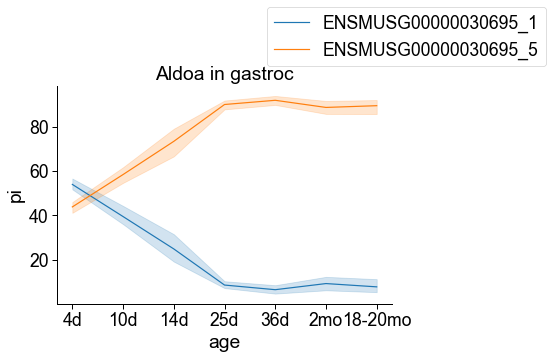

In [14]:
# if feat == 'ic':
# pi_df = swan.calc_pi(sg.tss_adata, sg.tss_adata.var, obs_col='dataset')
# pi_df = pi_df[0].sparse.to_dense()
gene = 'Aldoa'
tissue = 'gastroc'
feat = 'tss'
# feat_ids = [1,2,5,6, 14]
make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=[1,5])

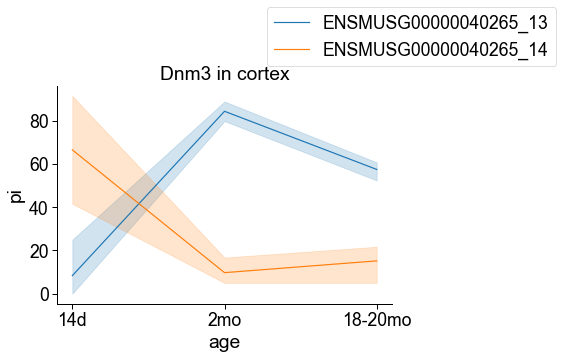

In [12]:
gene = 'Dnm3'
tissue = 'cortex'
feat = 'ic'
feat_ids = [13, 14]
make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=feat_ids)

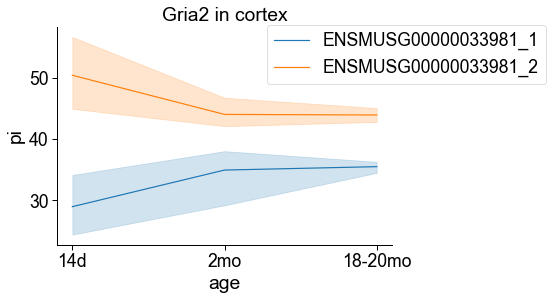

In [11]:
gene = 'Gria2'
tissue = 'cortex'
feat = 'ic'
feat_ids = [1, 2]
make_pi_line_plot(pi_df, gene, tissue, feat, feat_ids=feat_ids)